# Amazon

### Celem jest pokazanie, jak zastosować transfer wiedzy w bardziej zaawansowanym przykładzie.

Amazonia to zielone płuca świata. Niestety ilość drzew maleje w dość szybkim czasie. Ciężko już manualnie utrzymać nad tym kontrolę, dlatego pojawił się pomysł, żeby śledzić to z kosmosu.
A konkretnie robić zdjęcia satelitarne i wykrywać kawałki terenu, gdzie kiedyś las był, a teraz już go nie ma :(.

Tutaj znajdziesz więcej [szczegółów](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space).


![](../input/amazon/amazon_examples.png)

In [14]:
import pandas as pd 
import numpy as np 
np.random.seed(0)
import os.path
# import os
import gc

import tensorflow.keras as k
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D

from tensorflow.keras.applications import ResNet50, VGG16

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import fbeta_score
from tensorflow.keras.optimizers import Adam

import cv2
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Wczytujemy dane:

In [15]:
df_train = pd.read_csv('../input/amazon/train_v2.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Przygotowujemy odpowiedzi (`lables`).

In [16]:
all_labels = df_train['tags'].map(lambda x: x.split(' ')).values
labels = list(set([y for x in all_labels for y in x]))

print( len(labels), labels )

17 ['agriculture', 'water', 'blooming', 'cultivation', 'bare_ground', 'road', 'artisinal_mine', 'habitation', 'conventional_mine', 'primary', 'selective_logging', 'partly_cloudy', 'cloudy', 'blow_down', 'haze', 'clear', 'slash_burn']


Jest 17 unikalnych klas. Do jednego zdjęcia może być przypisana jedna lub więcej klas.

- `selective_logging`
- `artisinal_mine`
- `water`
- `haze`
- `primary`
- `habitation`
- `cultivation`
- `road`
- `conventional_mine`
- `bare_ground`
- `blow_down`
- `partly_cloudy`
- `clear`
- `cloudy`
- `blooming`
- `slash_burn`
- `agriculture`

Czas zobaczyć dane...

## Wczytywanie danych

In [17]:
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in df_train['tags'].map(lambda x: x.split(' ')).values:
    for l2 in l:
        counts[l2] += 1

counts

defaultdict(int,
            {'haze': 2697,
             'primary': 37513,
             'agriculture': 12315,
             'clear': 28431,
             'water': 7411,
             'habitation': 3660,
             'road': 8071,
             'cultivation': 4547,
             'slash_burn': 209,
             'cloudy': 2089,
             'partly_cloudy': 7261,
             'conventional_mine': 100,
             'bare_ground': 862,
             'artisinal_mine': 339,
             'blooming': 332,
             'selective_logging': 340,
             'blow_down': 101})

<BarContainer object of 17 artists>

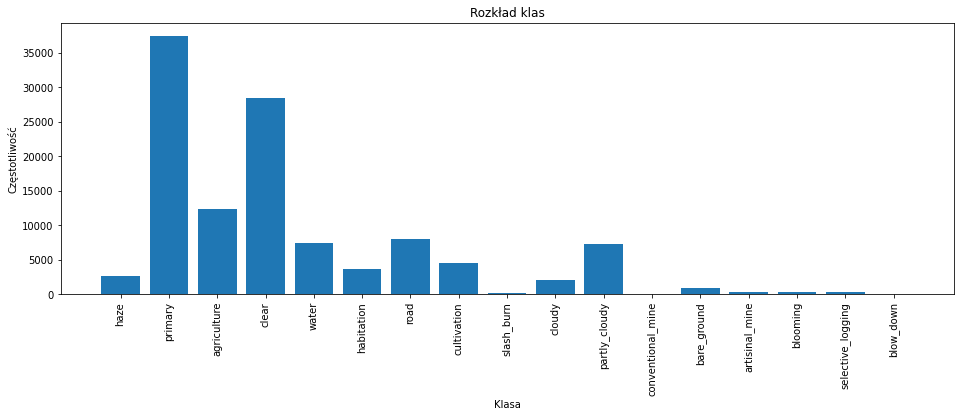

In [18]:
plt.figure(figsize=(16, 5))
plt.title("Rozkład klas")
idxs = range(len(counts.values()))
plt.xticks(idxs, counts.keys(), rotation='vertical')
plt.xlabel("Klasa")
plt.ylabel("Częstotliwość")
plt.bar( idxs, counts.values() )

## Sortujemy wynik

In [19]:
labels_df = df_train.copy()
for label in labels:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

labels_df.head()

,image_name,tags,agriculture,water,blooming,cultivation,bare_ground,road,artisinal_mine,habitation,conventional_mine,primary,selective_logging,partly_cloudy,cloudy,blow_down,haze,clear,slash_burn
0,train_0,haze primary,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,train_1,agriculture clear primary water,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,train_2,clear primary,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,train_3,clear primary,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,train_4,agriculture clear habitation primary road,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0


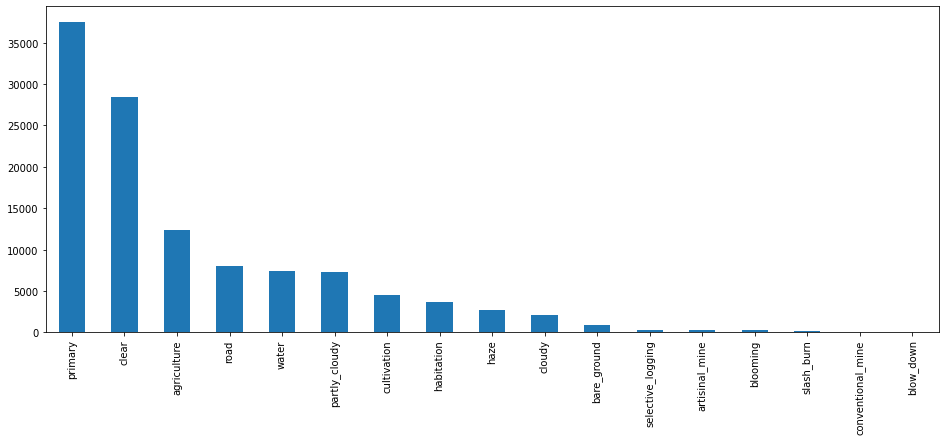

In [20]:
labels_df[labels].sum().sort_values(ascending=False).plot.bar(figsize=(16, 6));

,agriculture,water,blooming,cultivation,bare_ground,road,artisinal_mine,habitation,conventional_mine,primary,selective_logging,partly_cloudy,cloudy,blow_down,haze,clear,slash_burn
agriculture,12315,2712,32,3377,225,6034,38,2737,24,11972,65,2493,0,22,672,9150,119
water,2712,7411,16,868,206,2125,299,915,26,7001,49,1295,0,3,613,5502,24
blooming,32,16,332,35,3,10,0,4,0,332,7,17,0,1,4,311,2
cultivation,3377,868,35,4477,89,1294,18,895,4,4455,58,748,0,8,202,3527,126
bare_ground,225,206,3,89,862,323,40,163,10,683,13,74,0,4,41,747,10
road,6034,2125,10,1294,323,8071,110,2786,59,7728,151,1382,0,2,394,6295,36
artisinal_mine,38,299,0,18,40,110,339,29,4,324,6,27,0,0,5,307,0
habitation,2737,915,4,895,163,2786,29,3660,36,3469,13,441,0,3,129,3090,41
conventional_mine,24,26,0,4,10,59,4,36,100,94,0,28,0,0,2,70,0
primary,11972,7001,332,4455,683,7728,324,3469,94,37513,340,7175,0,98,2670,27668,209


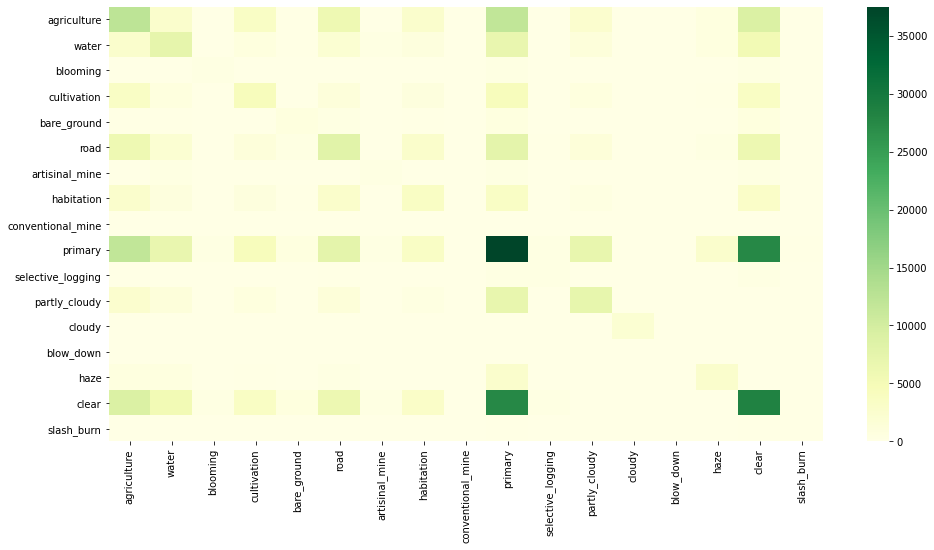

In [21]:
plt.figure(figsize=(16, 8))
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix, cmap="YlGn")
    return c_matrix
    
make_cooccurence_matrix(labels)

## Pytania 7.5.1
1. Jakie wnioski możesz wyciągnąć?
2. Czy są wzajemnie wykluczające się klasy, jeśli tak to jakie? Dlaczego tak jest? 
3. Jakie już widzisz wyzwania?
4. Kilka komórek wyżej były zrobione dwa barplot’y (częstotliwość klas). Jeden z nich był posortowany. Jak myślisz, który jest lepszy i dlaczego?

## Odpowiedzi 7.5.1
1. ???
2. ???
3. ???
4. ???

## Wizualizacja

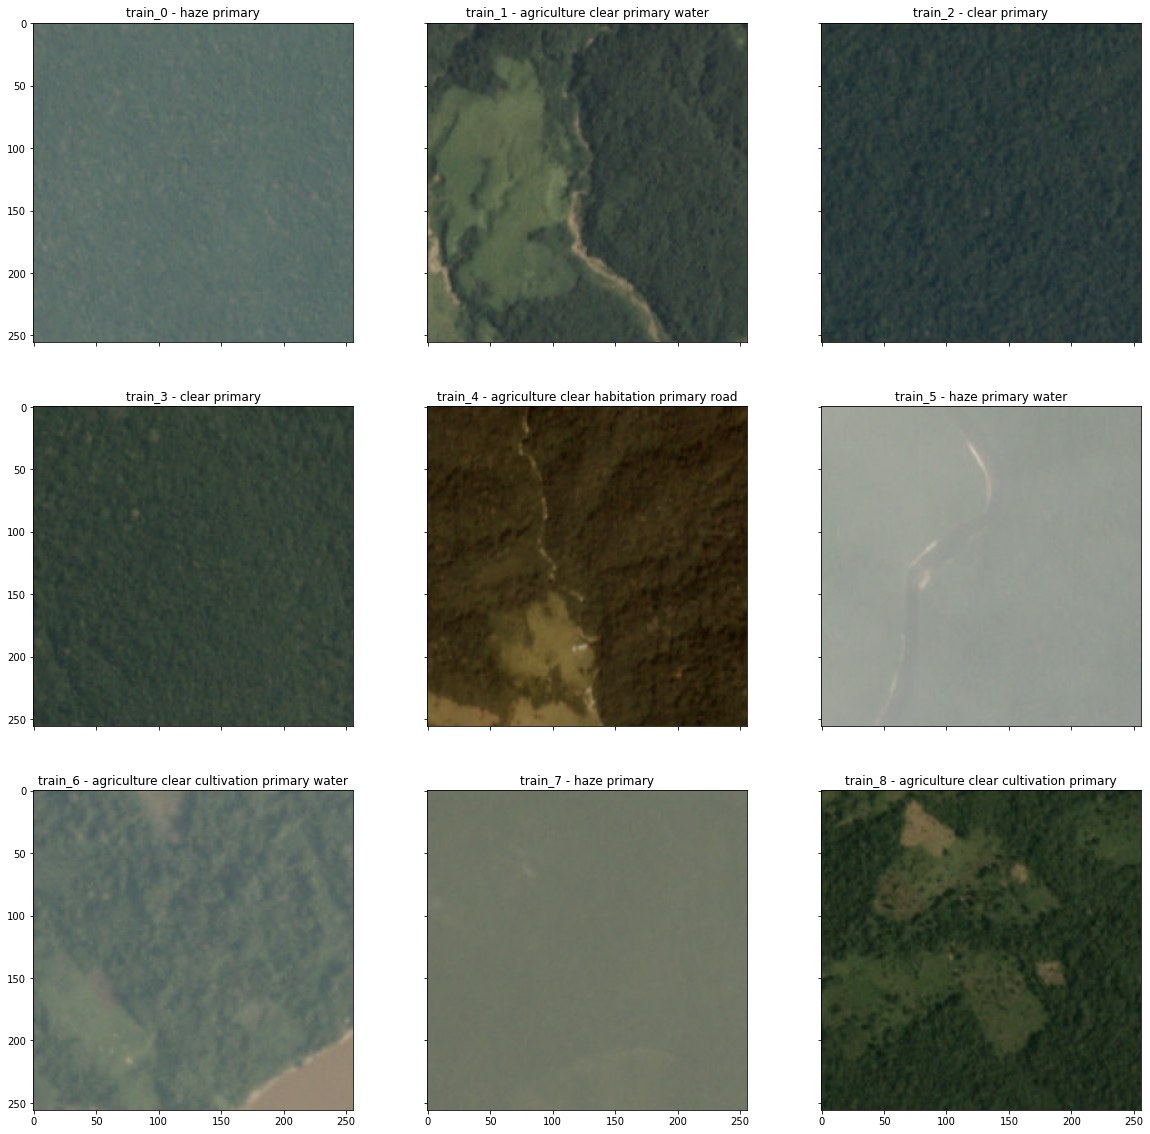

In [22]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train[:9].values:
    if False == os.path.exists('../input/amazon/train-jpg/{}.jpg'.format(f)): continue
        
    img = cv2.imread('../input/amazon/train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    #ax[i // 4, i % 4].show()
    i += 1
    
plt.show()

## Wczytywanie danych

In [23]:
def read_data(df_train, labels, resize=(32, 32)):
    X_train = []
    y_train = []

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}

    for f, tags in tqdm(df_train.values, miniters=1000):
        if False == os.path.exists('../input/amazon/train-jpg/{}.jpg'.format(f)): continue

        img = cv2.imread('../input/amazon/train-jpg/{}.jpg'.format(f))
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1 

        X_train.append(cv2.resize(img, resize))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    X_train = np.array(X_train, np.float16) / 255.
    
    split = 5000#35000
        
    return X_train[:split], X_train[split:], y_train[:split], y_train[split:]

In [24]:
X_train, X_test, y_train, y_test = read_data(df_train, labels, resize=(32, 32))

100%|██████████| 40479/40479 [00:57<00:00, 709.57it/s]


## Architektura (Base Line)

Zbudujmy na początek najprostszą architekturę, która składa się z dwóch bloków (blok: `conv` + `maxpool`) i sprawdźmy, jaka jest jakość tego modelu.

In [25]:
def get_simple_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25), 
        
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Flatten(),
        
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(17, activation='sigmoid') 
    ])

model = get_simple_cnn()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

### Trenujemy model

In [26]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/5
40/40 [==============================] - 11s 283ms/step - loss: 0.3138 - accuracy: 0.4468 - val_loss: 0.3245 - val_accuracy: 0.5255
Epoch 2/5
40/40 [==============================] - 10s 260ms/step - loss: 0.2381 - accuracy: 0.4726 - val_loss: 0.2487 - val_accuracy: 0.4911
Epoch 3/5
40/40 [==============================] - 13s 326ms/step - loss: 0.2211 - accuracy: 0.4794 - val_loss: 0.2255 - val_accuracy: 0.4932
Epoch 4/5
40/40 [==============================] - 11s 273ms/step - loss: 0.2133 - accuracy: 0.4902 - val_loss: 0.2212 - val_accuracy: 0.4908
Epoch 5/5
40/40 [==============================] - 11s 278ms/step - loss: 0.2084 - accuracy: 0.4922 - val_loss: 0.2078 - val_accuracy: 0.4943


### Sprawdzamy wynik

In [27]:
y_pred = model.predict(X_test, batch_size=128)
score = fbeta_score(y_test, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

Test score (f1):  0.789903273381523
Error: 21.01%


### Krzywa uczenia sie

In [28]:
def draw_learning_curve(history, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

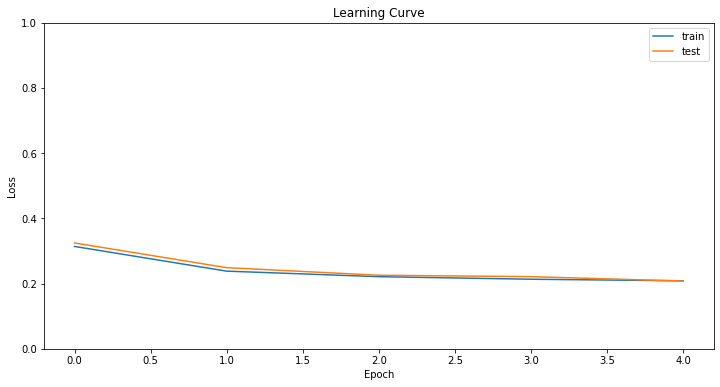

In [29]:
draw_learning_curve(history, key='loss', ylim=(0, 1))

## Architektura #2

Trochę bardziej złożona architektura, tym razem już mamy trzy bloki (blok: `conv` + `conv` + `maxpool`).

In [30]:
def get_doubled_cnn3_nodropout():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(512, activation='relu'),
        Dense(17, activation='sigmoid') 
    ])


model = get_doubled_cnn3_nodropout()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)        

## Trenujemy #2

In [ ]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/5
40/40 [==============================] - 20s 493ms/step - loss: 0.3383 - accuracy: 0.4690 - val_loss: 0.2747 - val_accuracy: 0.4674
Epoch 2/5
40/40 [==============================] - 19s 473ms/step - loss: 0.2550 - accuracy: 0.4690 - val_loss: 0.2434 - val_accuracy: 0.4674
Epoch 3/5
40/40 [==============================] - 20s 497ms/step - loss: 0.2419 - accuracy: 0.4690 - val_loss: 0.2339 - val_accuracy: 0.4674
Epoch 4/5
27/40 [===================>..........] - ETA: 2s - loss: 0.2261 - accuracy: 0.4731

## Sprawdzamy #2

In [ ]:
y_pred = model.predict(X_test, batch_size=128)
score = fbeta_score(y_test, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

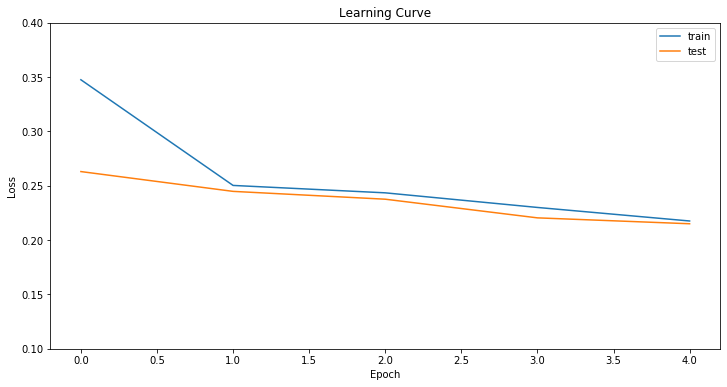

In [24]:
draw_learning_curve(history, key='loss', ylim=(0.1, 0.4))

## Architektura #3

Dodajemy kolejny blok do naszej architektury.

In [28]:
del X_train, X_test, y_train, y_test
gc.collect()
X_train, X_test, y_train, y_test = read_data(df_train, labels, resize=(64, 64))

15690

In [29]:
def get_doubled_cnn4_nodropout():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Flatten(), 
        
        Dense(256, activation='relu'),
        Dense(17, activation='sigmoid') 
    ])


model = get_doubled_cnn4_nodropout()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 128)      

## Trenujemy #3

In [30]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 5000 samples, validate on 35479 samples
Epoch 1/5
5000/5000 [==============================] - 47s 9ms/sample - loss: 0.3168 - accuracy: 0.8855 - val_loss: 0.2486 - val_accuracy: 0.9053
Epoch 2/5
5000/5000 [==============================] - 46s 9ms/sample - loss: 0.2465 - accuracy: 0.9042 - val_loss: 0.2439 - val_accuracy: 0.9053
Epoch 3/5
5000/5000 [==============================] - 45s 9ms/sample - loss: 0.2431 - accuracy: 0.9046 - val_loss: 0.2600 - val_accuracy: 0.8923
Epoch 4/5
5000/5000 [==============================] - 53s 11ms/sample - loss: 0.2353 - accuracy: 0.9077 - val_loss: 0.2386 - val_accuracy: 0.9034
Epoch 5/5
5000/5000 [==============================] - 47s 9ms/sample - loss: 0.2257 - accuracy: 0.9098 - val_loss: 0.2315 - val_accuracy: 0.9043


## Sprawdzamy #3

In [32]:
y_pred = model.predict(X_test, batch_size=128)
score = fbeta_score(y_test, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

Test score (f1):  0.7529831085918177
Error: 24.70%


Hm... Nie chce iść dalej, zablokowało się przy ~75%. Spróbujmy użyć teraz innego modelu, np. `VGG16` i zobaczmy, na ile wynik będzie lepszy.

## VGG

In [33]:
del X_train, X_test, y_train, y_test
gc.collect()

X_train, X_test, y_train, y_test = read_data(df_train, labels, resize=(48, 48))

100%|██████████| 40479/40479 [00:52<00:00, 777.37it/s]


In [34]:
def fbeta_score_K(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

    return result

`base_model` - to będzie model bazowy oparty na już wytrenowanym modelu `VGG16`, do tego modelu dodajemy jedynie kawałek interpretacyjny, czyli to:

```
Dense(128, activation='relu'),
Dropout(0.2),
Dense(17, activation='sigmoid')
```

In [35]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential([
    base_model,
    
    Flatten(), 
        
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(17, activation='sigmoid')
    
])

optimizer = Adam(0.003, decay=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', fbeta_score_K])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 17)                2193      
Total params: 14,782,545
Trainable params: 67,857
Non-trainable params: 14,714,688
_________________________________________________________________


Trenujemy nasz model.

In [36]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 5000 samples, validate on 35479 samples
Epoch 1/2
5000/5000 [==============================] - 83s 17ms/sample - loss: 0.2909 - accuracy: 0.8872 - fbeta_score_K: 0.5582 - val_loss: 0.2077 - val_accuracy: 0.9197 - val_fbeta_score_K: 0.6209
Epoch 2/2
5000/5000 [==============================] - 82s 16ms/sample - loss: 0.2064 - accuracy: 0.9206 - fbeta_score_K: 0.6363 - val_loss: 0.1876 - val_accuracy: 0.9277 - val_fbeta_score_K: 0.6654


Sprawdzamy wynik.

In [37]:
y_pred = model.predict(X_test, batch_size=128)
score = fbeta_score(y_test, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

Test score (f1):  0.814236737657246
Error: 18.58%


### Kontynuujemy, ale z mniejszym krokiem.

In [38]:
optimizer = Adam(0.0001, decay=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', fbeta_score_K])


history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=3,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 5000 samples, validate on 35479 samples
Epoch 1/3
5000/5000 [==============================] - 83s 17ms/sample - loss: 0.1922 - accuracy: 0.9263 - fbeta_score_K: 0.6591 - val_loss: 0.1859 - val_accuracy: 0.9277 - val_fbeta_score_K: 0.6611
Epoch 2/3
5000/5000 [==============================] - 82s 16ms/sample - loss: 0.1917 - accuracy: 0.9256 - fbeta_score_K: 0.6535 - val_loss: 0.1852 - val_accuracy: 0.9280 - val_fbeta_score_K: 0.6637
Epoch 3/3
5000/5000 [==============================] - 82s 16ms/sample - loss: 0.1908 - accuracy: 0.9267 - fbeta_score_K: 0.6628 - val_loss: 0.1845 - val_accuracy: 0.9283 - val_fbeta_score_K: 0.6655


In [39]:
y_pred = model.predict(X_test, batch_size=128)
score = fbeta_score(y_test, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

Test score (f1):  0.8192198181648972
Error: 18.08%


Ta druga iteracja (z mniejszym krokiem) może trwać dłużej (np. 10, 20 lub więcej iteracji), ale na to trzeba więcej zasobów. Teraz celem było pokazanie, że VGG jest lepszy niż poprzednie modele już o 5%.

### Kontynuujemy, ale odmrażamy wszystko.


Uwaga! To zadanie już jest dość złożone, więc obliczenia mogą trochę potrwać. Dlatego aby nieco przyspieszyć eksperymenty (w szczególności bardziej zaawansowane), to polecam spróbować z użyciem GPU na Colab. Przygotowałem dla Ciebie [ten notebook](https://colab.research.google.com/drive/1pG2558PaP-l2Xa_EqJph0O4OAZswZqJV).

## Zadanie 7.5.2

Spróbuj odmrozić kilka lub więcej warstw konwolucyjnych i uruchomić model. Tylko ostrożnie, bo może się przeuczyć.

Nawet przy 2 iteracjach możesz usprawnić wynik o 4-5% (czyli ok. 15% błędu).


## *Podpowiedzi*:
### (1)
```
for layer in model.layers[0].layers[1:]: #odmrażamy wszystko oprócz "input"
    layer.trainable = True
    
for layer in model.layers[0].layers:
    print(layer.name, layer. trainable)
    
    
model.summary()
```

### (2)
Warto zapisywać najlepszy stan sieci (wagi) na dysku, jeśli pójdziesz w złym kierunku, to wtedy wczytujesz ten stan, który został zapisany - należy zrobić `callback`.


```
callbacks = [
    ModelCheckpoint('../output/vgg.hdf5', monitor='val_loss', save_best_only=True, verbose=2, save_weights_only=False),
    EarlyStopping(monitor='val_loss', patience=5, verbose=0)
]

```

`Callbacks` przekazuje się do `modlel.fit(..., callbacks=callbacks)`

Wczytują się w ten sposób wagi .


`model.load_weights('../output/vgg.hdf5')`

### (3)

```
optimizer = Adam(0.0001, decay=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', fbeta_score_K])


history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(X_test, y_test))
          
y_pred = model.predict(X_test, batch_size=128)
score = fbeta_score(y_test, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))
```



In [ ]:
## YOUR CODE HERE

## Zadanie 7.5.3 (opcjonalne)

Spróbuj podobnego podejścia jak z VGG tylko teraz z innymi architekturami (co najmniej ResNet50).

In [ ]:
## YOUR CODE HERE

## Twoja opinia
Proszę podziel się opinią o tym module wypełniając [formularz](https://forms.gle/vHJwTrnJzrxFGCsz6). To pomoże mi lepiej zrozumieć, co warto ulepszyć i rozszerzyć. Możesz również zadać pytania :) 

## Przydatne linki:
- [Discussion](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/discussion)
- [We need to save the lungs of our planet](https://medium.com/@ananya.garg197/can-deep-learning-save-the-amazon-rainforest-dee3602d9d80)
- [Kernels](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/kernels)
